# **Different ways of initializing parameters**

---

In [1]:
# Getting python's version

import sys

print(sys.version)

3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]


In [2]:
# Importing numpy package
import numpy as np

print(np.__version__)

1.18.5


## **Table of Contents**



1.  Initialize parameters
2.  Activation functions (Sigmoid, RELU)
3.  Gradients of activation functions (Sigmoid, RELU)
4.  Forward Propagation
5.  Computing cost
6.  Backpropagation
7.  Update parameters
8.  Neural Network Model
9.  Predict classes function
10. Predict accuracy
11. Testing



---

*** Neural Network Structure ***

    layers     : input - [L-1] hidden - output
    activations:         [L-1] Relu   - sigmoid

    cost function: 
        logprobs = np.multiply(-np.log(AL),Y) + np.multiply(-np.log(1 - AL), 1 - Y)
        cost = 1./m * np.nansum(logprobs)

## **Initialize parameters**

    * Some of the different ways for parameters initialization *

      1. Zeros
      2. Random
      3. He initialization
      4. Xavier initialization

In [3]:
# *** Different methods of initializing parameters ***

# Zeros initialization
def initialize_parameters_zeros(layers_dims):
    parameters = {}
    L = len(layers_dims) # number of layers

    for l in range(1, L):
        parameters[f'W{l}'] = np.zeros((layers_dims[l], layers_dims[l-1]))
        parameters[f'b{l}'] = np.zeros((layers_dims[l], 1))

    return parameters


# Random initialization
def initialize_parameters_random(layers_dims, init_const=0.01, seed=None):
    if seed:
        np.random.seed(seed)

    parameters = {}
    L = len(layers_dims) # number of layers

    for l in range(1, L):
        parameters[f'W{l}'] = np.random.randn(layers_dims[l], layers_dims[l-1]) * init_const
        parameters[f'b{l}'] = np.zeros((layers_dims[l], 1))

    return parameters


# He initialization
def initialize_parameters_he(layers_dims, seed=None):
    # Use when you're using `RELU` as activation function
    if seed:
        np.random.seed(seed)

    parameters = {}
    L = len(layers_dims) # number of layers
    
    for l in range(1, L):
        parameters[f'W{l}'] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(2/layers_dims[l-1]) 
        parameters[f'b{l}'] = np.zeros((layers_dims[l], 1))
    
    return parameters


# Xavier initialization
def initialize_parameters_xavier(layers_dims, seed=None):
    # Use when you're using `tanh` as activation function

    if seed:
        np.random.seed(seed)

    parameters = {}
    L = len(layers_dims) # number of layers
    
    for l in range(1, L):
        parameters[f'W{l}'] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(1/layers_dims[l-1]) 
        parameters[f'b{l}'] = np.zeros((layers_dims[l], 1))
    
    return parameters

# *** # Different methods of initializing parameters ***


# Initialize parameters
def initialize_parameters(layers_dims, initialization='random', init_const=0.01, seed=None):
    if initialization == 'random':
        return initialize_parameters_random(layers_dims, init_const, seed)
    elif initialization == 'he':
        return initialize_parameters_he(layers_dims, seed)
    elif initialization == 'xavier':
        return initialize_parameters_xavier(layers_dims, seed)
    elif initialization == 'zeros':
        return initialize_parameters_zeros(layers_dims)

## **Activation functions**

In [4]:
# Sigmoid function
def sigmoid(Z):
    A = 1/(1 + np.exp(-Z))
    cache = Z
    return A, cache

# Relu
def relu(Z):
    A = np.maximum(0, Z)
    cache = Z
    return A, cache

## **Gradients of activation functions**

In [5]:
""" 
    Used in backpropagation 

    dA -- post-activation gradient, of any shape
    dZ -- Gradient of the cost with respect to Z
"""

# Sigmoid
def sigmoid_backward(dA, cache):
    Z = cache
    S = 1/(1 + np.exp(-Z))
    dZ = dA * S * (1 - S)
    return dZ

# Relu
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

## **Forward Propagation**

In [6]:
"""
    Forward propagation structure:
        input layer -> [Linear -> Relu] * (L - 1) -> [Linear -> Sigmoid] (output layer)

    One unit does two work first calculate Z (linear forward) and then calculate A (activation)
"""


# linear forward
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    return Z, cache


# Combining linear forward and activation steps
def linear_activation_forward(A_prev, W, b, activation):
    # Linear forward step
    Z, linear_cache = linear_forward(A_prev, W, b)

    # Forward activation step
    if activation == 'relu':
        A, activation_cache = relu(Z)
    elif activation == 'sigmoid':
        A, activation_cache = sigmoid(Z)

    cache = (linear_cache, activation_cache)
    return A, cache


# Forward propagation for L layers
def forward_propagation(X, parameters, num_of_layers):
    caches = []
    A = X
    L = num_of_layers

    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters[f'W{l}'], parameters[f'b{l}'], 'relu')
        caches.append(cache)

    # Implement LINEAR -> SIGMOID for ouput layer. Add "cache" to the "caches" list
    AL, cache = linear_activation_forward(A, parameters[f'W{L}'], parameters[f'b{L}'], 'sigmoid')
    caches.append(cache)

    return AL, caches

## **Compute cost**

In [7]:
def compute_cost(AL, Y):
    m = Y.shape[1] # number of examples

    logprobs = np.multiply(-np.log(AL),Y) + np.multiply(-np.log(1 - AL), 1 - Y)
    cost = 1./m * np.nansum(logprobs)

    cost = np.squeeze(cost) # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).

    return cost

## **Backpropagation**

In [8]:
"""
    Backward propagation structure
        input layer -> [Linear -> Relu] * (L - 1) -> [Linear -> Sigmoid] (output layer)

    One unit does two work first calculate Z (linear forward) and then calculate A (activation)
"""


# Linear backward step
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1] # number of examples

    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db


# Combining linear backward and activation steps
def linear_activation_backward(dA, cache, activation):
    # Retriving cache
    linear_cache, activation_cache = cache

    # Backward activation step
    if activation == 'relu':
        dZ = relu_backward(dA, activation_cache)
    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)

    # Linear backward step
    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db


# Backward propagation for L layers
def backward_propagation(AL, Y, caches):
    grads = {}
    L = len(caches) # number of layers
    m = AL.shape[1] # number of examples
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL

    # Initializing backpropagation
    dAL = - np.divide(Y, AL) + np.divide(1 - Y, 1 - AL)

    # Lth layer (SIGMOID -> LINEAR) gradients
    current_cache = caches[L - 1]
    grads[f'dA{L-1}'], grads[f'dW{L}'], grads[f'db{L}'] = linear_activation_backward(dAL, current_cache, 'sigmoid')

    # Loop from L=L-1 to L=1
    for l in reversed(range(1, L)):
        # lth layer: (RELU -> LINEAR) gradients.

        current_cache = caches[l - 1]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads[f'dA{l}'], current_cache, 'relu')
                                                                                                  
        grads[f'dA{l - 1}'] = dA_prev_temp
        grads[f'dW{l}'] = dW_temp
        grads[f'db{l}'] = db_temp

    """
        Below commented loop is another way to implement above loop
        but it is made simpler to understand what's going on.
    """

    # # Loop from L=L-2 to L=0
    # for l in reversed(range(L - 1)):
    #     # lth layer: (RELU -> LINEAR) gradients.

    #     current_cache = caches[l]
    #     dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads[f'dA{l + 1}'], current_cache, 'relu')
                                                                                                  
    #     grads[f'dA{l}'] = dA_prev_temp
    #     grads[f'dW{l + 1}'] = dW_temp
    #     grads[f'db{l + 1}'] = db_temp

    return grads

## **Update parameters**

In [9]:
def update_parameters(parameters, grads, learning_rate, num_of_layers):
    L = num_of_layers # number of layers

    # Updating parameters
    for l in range(1, L+1):
        parameters[f'W{l}'] = parameters[f'W{l}'] - learning_rate * grads[f'dW{l}']
        parameters[f'b{l}'] = parameters[f'b{l}'] - learning_rate * grads[f'db{l}']

    return parameters

## **Neural Network Model**

In [10]:
def model(X, Y, layers_dims, learning_rate=0.01, initialization='he', init_const=0.01, num_of_iterations=10000, print_cost=True, print_cost_after=1000, seed=None):
    L = len(layers_dims) - 1 # number of layers

    # Initialize parameters
    parameters = initialize_parameters(layers_dims, initialization, init_const, seed)

    # Gradient Descent
    for i in range(num_of_iterations):
        # Forward propagation
        AL, caches = forward_propagation(X, parameters, L)

        # Compute cost
        cost = compute_cost(AL, Y)

        # Backward propagation
        grads = backward_propagation(AL, Y, caches)

        # Updating parameters
        parameters = update_parameters(parameters, grads, learning_rate, L)

        # Priniting cost after given iterations
        if print_cost and i % print_cost_after == 0:
            print ("Cost after iteration %i: %f" % (i, cost))

    return parameters

## **Predict classes function**

In [11]:
def predict(parameters, X, num_of_layers, threshold=0.5):
    L = num_of_layers
    AL, caches = forward_propagation(X, parameters, L)
    AL[AL < threshold] = 0
    AL[AL >= threshold] = 1
    return AL # prediction

# **Predict accuracy**

In [12]:
def predict_accuracy(X, Y, parameters, num_of_layers, threshold=0.5):
    m = X.shape[1] # number of examples
    L = num_of_layers
    AL = predict(parameters, X, L, threshold)
    accuracy = np.sum((AL == Y) / m)
    return accuracy

---

## **Testing**

In [13]:
# Importing packages

import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model

In [14]:
# Helper functions for generating datasets and plotting


def load_dataset():
    np.random.seed(1)
    train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
    np.random.seed(2)
    test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    test_X = test_X.T
    test_Y = test_Y.reshape((1, test_Y.shape[0]))
    return train_X, train_Y, test_X, test_Y


def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)


def predict_dec(parameters, X, num_of_layers):
    # Predict using forward propagation and a classification threshold of 0.5
    AL, cache = forward_propagation(X, parameters, num_of_layers)
    predictions = (AL>0.5)
    return predictions


def load_extra_datasets():  
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
    blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2)
    
    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure

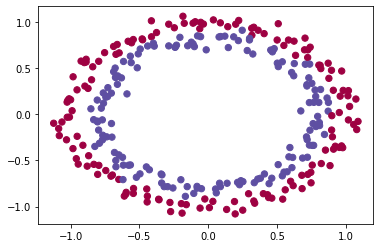

In [15]:
# load image dataset: blue/red dots in circles
train_X, train_Y, test_X, test_Y = load_dataset()

In [16]:
# Neural Network Structure
layers_dims = [train_X.shape[0], 10, 5, 1]

Cost after iteration 0: 0.693147
Cost after iteration 10000: 0.693147
Cost after iteration 20000: 0.693147
On the train set:  0.5
On the test set:  0.5


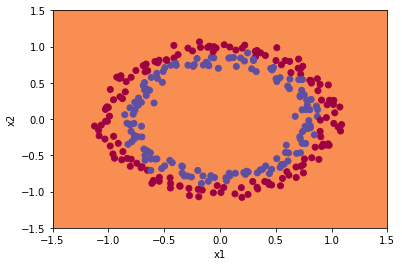

In [17]:
# Zero Initialization

parameters = model(train_X, train_Y, layers_dims, initialization='zeros', learning_rate=0.01, num_of_iterations=30000, print_cost=True, print_cost_after=10000)

predictions_train = predict_accuracy(train_X, train_Y, parameters, len(layers_dims) - 1)
print ("On the train set: ", predictions_train)
predictions_test = predict_accuracy(test_X, test_Y, parameters, len(layers_dims) - 1)
print ("On the test set: ", predictions_test)

axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T, len(layers_dims) - 1), train_X, train_Y)

Cost after iteration 0: 0.693147
Cost after iteration 10000: 0.693147
Cost after iteration 20000: 0.693147
On the train set:  0.5433333333333333
On the test set:  0.56


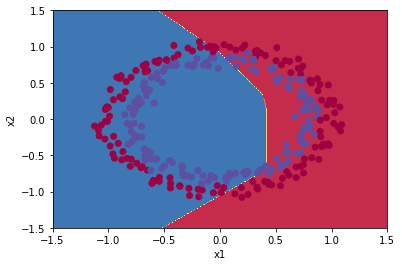

In [18]:
# Random Initialization

parameters = model(train_X, train_Y, layers_dims, initialization='random', learning_rate=0.01, num_of_iterations=30000, print_cost=True, print_cost_after=10000)

predictions_train = predict_accuracy(train_X, train_Y, parameters, len(layers_dims) - 1)
print ("On the train set: ", predictions_train)
predictions_test = predict_accuracy(test_X, test_Y, parameters, len(layers_dims) - 1)
print ("On the test set: ", predictions_test)

axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T, len(layers_dims) - 1), train_X, train_Y)

Cost after iteration 0: 0.735197
Cost after iteration 10000: 0.288322
Cost after iteration 20000: 0.048206
On the train set:  0.9933333333333335
On the test set:  0.96


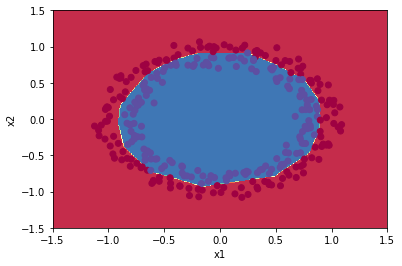

In [19]:
# He Initialization

parameters = model(train_X, train_Y, layers_dims, initialization='he', learning_rate=0.01, num_of_iterations=30000, print_cost=True, print_cost_after=10000)

predictions_train = predict_accuracy(train_X, train_Y, parameters, len(layers_dims) - 1)
print ("On the train set: ", predictions_train)
predictions_test = predict_accuracy(test_X, test_Y, parameters, len(layers_dims) - 1)
print ("On the test set: ", predictions_test)

axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T, len(layers_dims) - 1), train_X, train_Y)

Cost after iteration 0: 0.692645
Cost after iteration 10000: 0.189934
Cost after iteration 20000: 0.048845
On the train set:  0.9933333333333335
On the test set:  0.94


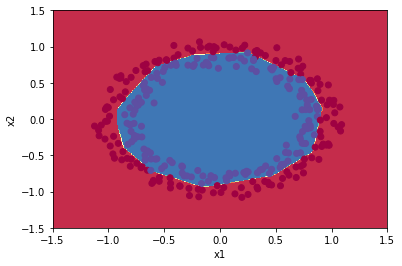

In [20]:
# Xavier Initialization

parameters = model(train_X, train_Y, layers_dims, initialization='xavier', learning_rate=0.01, num_of_iterations=30000, print_cost=True, print_cost_after=10000)

predictions_train = predict_accuracy(train_X, train_Y, parameters, len(layers_dims) - 1)
print ("On the train set: ", predictions_train)
predictions_test = predict_accuracy(test_X, test_Y, parameters, len(layers_dims) - 1)
print ("On the test set: ", predictions_test)

axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T, len(layers_dims) - 1), train_X, train_Y)

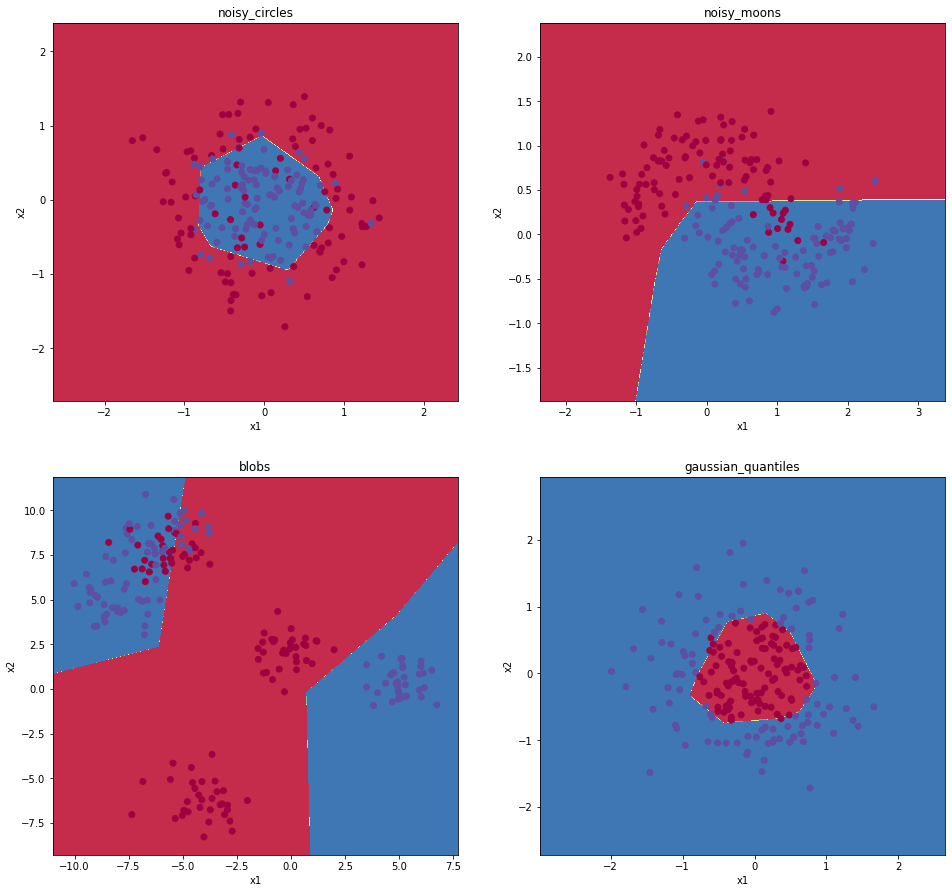

In [21]:
# Using other datasets

# using `he` initialization method for all

# Datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {
    'noisy_circles': noisy_circles,
    'noisy_moons': noisy_moons,
    'blobs': blobs,
    'gaussian_quantiles': gaussian_quantiles
}

plt.figure(figsize=(16, 32))

layers_dims = [2, 5, 1]
for i, dataset in enumerate(datasets):
    plt.subplot(4, 2, i+1)
    plt.title(dataset)
    X, Y = datasets[dataset]
    X, Y = X.T, Y.reshape(1, Y.shape[0])
    
    # make blobs binary
    if dataset == "blobs":
        Y = Y%2
    
    # Build a model with a n_h-dimensional hidden layer
    parameters = model(X, Y, layers_dims, initialization='he', learning_rate=0.01, num_of_iterations=30000, print_cost=False, print_cost_after=10000)
    # Plot the decision boundary
    plot_decision_boundary(lambda x: predict(parameters, x.T, len(layers_dims) - 1), X, Y)

---